In [48]:
import copy
import shutil
import math
import os
import time

import numpy as np
import pandas as pd
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as torchoptim
import torch.utils.data as torchdata
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchinfo

import utility as util

def show_image(ax, image):
    image = image / 2 + 0.5
    ax.imshow(image.numpy().transpose(1,2,0))

3dshapes is a dataset of 3D shapes procedurally generated from 6 ground truth independent latent factors. These factors are floor colour, wall colour, object colour, scale, shape and orientation.

All possible combinations of these latents are present exactly once, generating N = 480000 total images.

Latent factor values

- floor hue: 10 values linearly spaced in [0, 1]
- wall hue: 10 values linearly spaced in [0, 1]
- object hue: 10 values linearly spaced in [0, 1]
- scale: 8 values linearly spaced in [0, 1]
- shape: 4 values in [0, 1, 2, 3]
- orientation: 15 values linearly spaced in [-30, 30]

We varied one latent at a time (starting from orientation, then shape, etc), and sequentially stored the images in fixed order in the images array. The corresponding values of the factors are stored in the same order in the labels array.

The data is stored in a HDF5 file with the following fields:

- images: (480000 x 64 x 64 x 3, uint8) RGB images.
- labels: (480000 x 6, float64) Values of the latent factors.

In [2]:
# Get dataset properties
# Dataset is 480000*(64*64*3 + 6*8) // 10**6 or 5.921 GB in memory!

print("Names in H5 file:")
with h5py.File('../data/3dshapes.h5', 'r') as f:
    f.visit(print)
    # f['images'] has (480000 x 64 x 64 x 3, uint8) RGB images.
    print(f['images'].shape)
    # f['labels'] has (480000 x 6, float64) Values of the latent factors.
    print(f['labels'].shape)
    

Names in H5 file:
images
labels
(480000, 64, 64, 3)
(480000, 6)


label is 0
labels are of type float64


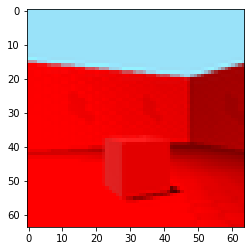

In [13]:
# Display one image
with h5py.File('../data/3dshapes.h5', 'r') as f:
    idx = 1
    ndimage = f['images'][idx]
    # shape label
    label = int( f['labels'][idx,4] )
    print("label is", label)
    print("labels are of type", f['labels'][idx].dtype)
    plt.imshow(ndimage)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]


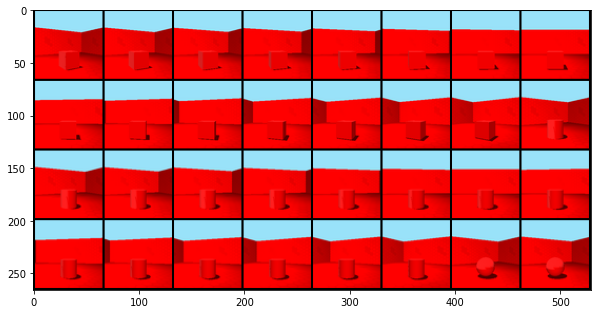

In [42]:
# Display multiple images as grid
with h5py.File('../data/3dshapes.h5', 'r') as f:
    ndimages = f['images'][:32]
    ndimages = ndimages.transpose(0,3,1,2)
    tensorimages = torchvision.utils.make_grid(torch.Tensor(ndimages))
    ndimages = tensorimages.numpy().transpose(1,2,0).astype(int)
    labels = f['labels'][:32,4].astype(int)
    print(labels)
    plt.figure(figsize=(10, 10))
    plt.imshow(ndimages)

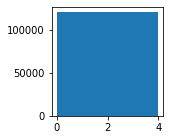

In [18]:
# Check there is even distribution of data
with h5py.File('../data/3dshapes.h5', 'r') as f:
    labels = f['labels'][:,4].astype(int)
    plt.figure(figsize=(2, 2))
    plt.hist(labels,bins=range(5))

In [49]:
image_transforms = {
    'train': T.Compose([
        # T.ToPILImage(),
        T.ToTensor(),
        T.Normalize(0.5, 0.5)  
    ]),
    'test': T.Compose([
        T.ToTensor(),
        T.Normalize(0.5, 0.5)
    ])
}

# converting ndarray to PIL image before doing image augmentations
# https://stackoverflow.com/questions/57079219/img-should-be-pil-image-got-class-torch-tensor

# https://discuss.pytorch.org/t/define-torch-dataloader-with-h5py-dataset/67968
# https://discuss.pytorch.org/t/dataloader-when-num-worker-0-there-is-bug/25643/16
# https://www.reddit.com/r/pytorch/comments/hlrjxg/whats_the_best_way_to_use_hdf5_data_in_a/

# Example of loading multiple HDF5 files
# https://towardsdatascience.com/hdf5-datasets-for-pytorch-631ff1d750f5

class HDF5Dataset(torchdata.Dataset):
    def __init__(self,
            datapath='../data/3dshapes.h5',
            transform=T.ToTensor()):
        self.datapath = datapath
        self.images = None
        self.labels = None
        self.transform = transform
        with h5py.File(self.datapath, 'r') as f:
            self.images = f['images'][:]
            self.labels = f['labels'][:,4]
            # f['images'] has (480000 x 64 x 64 x 3, uint8) RGB images.
            # f['labels'] has (480000 x 6, float64) Values of the latent factors.
        
    def __getitem__(self, idx):
        image  = self.images[idx]
        label = self.labels[idx].astype(int)
        image = self.transform(image)
        label = torch.tensor(label)
        return image, label
    
    def __len__(self):
        return self.labels.shape[0]

Load data (time consuming)

In [50]:
dataset = HDF5Dataset()

Training configuration

In [127]:
args = util.AttrDict(epochs=5, print_every=50, batch_size=32,
        learning_rate=0.01, train_frac=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


Create splits and data loader

In [130]:
n_train = int( args.train_frac*len(dataset) )
split = [n_train, len(dataset) - n_train]
generator = torch.Generator()
trainset, testset = torchdata.random_split(dataset, split, generator=generator)

rng = np.random.default_rng()

trainsampler = torchdata.SubsetRandomSampler(
        rng.choice(len(trainset), size=19200, replace=False), generator=generator)
trainloader = torchdata.DataLoader(
        trainset, sampler=trainsampler, batch_size=args.batch_size, num_workers=10)
testsampler = torchdata.SubsetRandomSampler(
        rng.choice(len(testset), size=3200, replace=False), generator=generator)
testloader = torchdata.DataLoader(
        testset, sampler=testsampler, batch_size=args.batch_size, num_workers=10)

print(len(trainset))
print(len(testset))
print(len(trainloader))
print(len(testloader))

432000
48000
600
100


array([3, 1, 1, 1, 3, 2, 3, 2, 1, 0, 2, 3, 3, 2, 2, 1, 3, 1, 1, 0, 0, 0,
       0, 1, 0, 2, 0, 1, 0, 1, 2, 3])

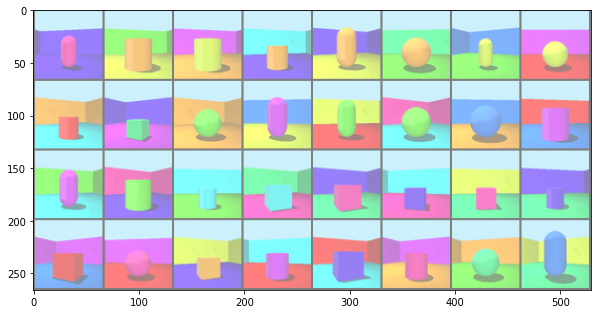

In [131]:
# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
show_image(plt.gca(), torchvision.utils.make_grid(images))
# print labels
# 3 -> pill; 2 -> ball; 1 -> cylinder; 0 -> square
labels.numpy()

Declare the model

In [132]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_size      = config.patch_size
        self.image_channels  = config.image_channels
        self.hidden_channels = config.hidden_channels
        self.output_size     = config.output_size
        self.filters         = config.filters
        try:
            self.strides  = config.strides
        except:
            self.strides  = [1 for _ in self.filters]
        try:
            self.paddings = config.paddings
        except:
            self.paddings = [0 for _ in self.filters]
        try:
            self.poolings = config.poolings
        except:
            self.poolings = [None for _ in self.filters]
        self.fc_features     = config.fc_features
        dummy = torch.ones((self.image_channels, *self.patch_size,)).unsqueeze(0) \
                * torch.tensor(float('nan'))
        conv_layers = []
        _channels = util.pairwise((self.image_channels, *self.hidden_channels,))
        for idx, ((_in_channel, _out_channel), _filter, _stride, _padding, _pool) in enumerate(
                zip(_channels, self.filters, self.strides, self.paddings, self.poolings)):
            conv = nn.Conv2d(_in_channel, _out_channel, _filter, stride=_stride, padding=_padding)
            conv_layers.append(conv)
            conv_layers.append(nn.ReLU())
            if _pool == 'max':
                pool = nn.MaxPool2d(2, 2)
                conv_layers.append(pool)
            elif _pool is None:
                pass
        conv_layers.append(nn.Flatten())
        self.convs = nn.Sequential(*conv_layers)
        dummy = self.convs(dummy)
        self.fc_inputs = dummy.numel()
        _features = util.pairwise((self.fc_inputs, *self.fc_features, self.output_size))
        fc_layers = []
        for idx, (_in_features, _out_features) in enumerate(_features):
            fc = nn.Linear(_in_features, _out_features)
            fc_layers.append(fc)
            fc_layers.append(nn.ReLU())
        self.fcs = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.convs(x)
#         x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

In [133]:
# Print Summary of Model

base_config = util.AttrDict(
    image_channels  = 3,
    patch_size      = [64, 64],
    hidden_channels = [64, 128, 256],
    filters = [5, 3, 3],
    strides = [2, 1, 1],
    poolings = ['max', 'max', None],
    fc_features = [128],
    output_size = 4)

# base model is overkill. Perfect classification in <2 epochs
config = util.AttrDict(**base_config)

# Parameters: 1,504
# Fails to converge / gets >90% accuracy. This is probably the list amount of parameters possible
def modify_1():
    config.hidden_channels = [6, 6, 6]
    config.filters = [5, 3, 3]
    config.strides = [2, 1, 1]
    config.poolings = ['max', 'max', None]
    config.fc_features = []
modify_1()

net = Net(config)
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(net, input_size=(1, 3, 64, 64), col_names=col_names, col_width=18)

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Kernel Shape
Net                                      --                 --                 --                 --
├─Sequential: 1-1                        [1, 3, 64, 64]     [1, 96]            --                 --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]     [1, 6, 30, 30]     456                [3, 6, 5, 5]
│    └─ReLU: 2-2                         [1, 6, 30, 30]     [1, 6, 30, 30]     --                 --
│    └─MaxPool2d: 2-3                    [1, 6, 30, 30]     [1, 6, 15, 15]     --                 --
│    └─Conv2d: 2-4                       [1, 6, 15, 15]     [1, 6, 13, 13]     330                [6, 6, 3, 3]
│    └─ReLU: 2-5                         [1, 6, 13, 13]     [1, 6, 13, 13]     --                 --
│    └─MaxPool2d: 2-6                    [1, 6, 13, 13]     [1, 6, 6, 6]       --                 --
│    └─Conv2d: 2-7                       [1, 6, 6, 6]       [


Test accuracy: 76.31%



Test accuracy: 98.44%



Test accuracy: 99.22%



Test accuracy: 99.31%



Test accuracy: 99.94%
Done.
Training time took 12.34510087966919 seconds


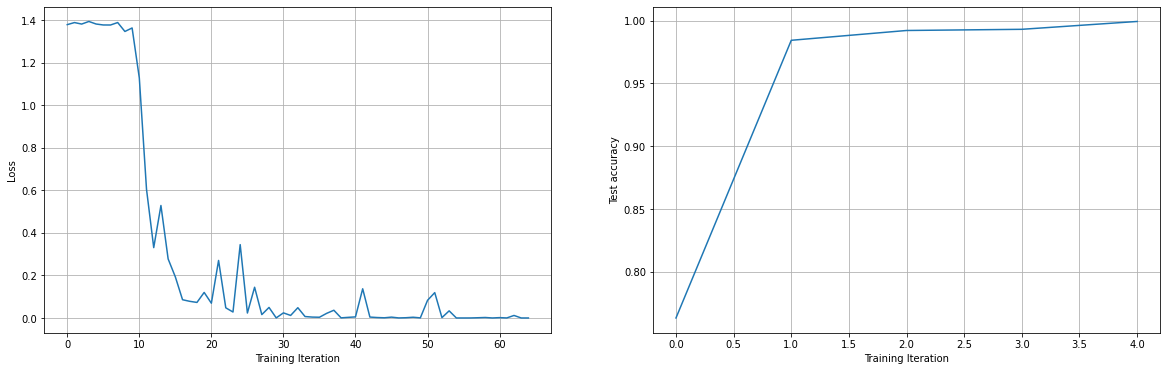

In [135]:
loss_over_time = []
acc_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9)
#     optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    scheduler = None
    
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Test accuracy: {:1.2%}".format(correct / total))
        acc_over_time.append(correct / total)
        if scheduler:
            scheduler.step()
    print("Done.")

net = Net(config).to(device)
should_create_new_instance = True
if should_create_new_instance:
    start = time.time()
    train(net, args, trainloader, testloader)
    end = time.time()
    print(f"Training time took {end - start} seconds")
    torch.save(net.state_dict(), './models/3dshapes_net.pth')
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.ravel()
    axes[0].plot(range(len(loss_over_time)), loss_over_time)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Training Iteration")
    axes[0].grid()
    axes[1].plot(range(len(acc_over_time)), acc_over_time)
    axes[1].set_ylabel("Test accuracy")
    axes[1].set_xlabel("Training Iteration")
    axes[1].grid()
else:
    net.load_state_dict(torch.load('./models/3dshapes_net.pth'))